generate vol surface for daily data

In [1]:
%load_ext autoreload
%reload_ext autoreload
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset, generate_predicted_vol_surfaces

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

# from src.volsurface import VAEPWVolSurface
from src.volsurface import TrainedDecoderVolSurface

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

In [2]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [3]:
DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [4]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-19 23:20:03] [INFO] src.utils.data_helper (50) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-19 23:20:14] [INFO] src.utils.data_helper (63) : Consecutive trading stats completed
[2025-04-19 23:20:15] [INFO] src.utils.data_helper (86) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-19 23:20:15] [INFO] src.utils.data_helper (91) : Moneyness calculation completed


In [10]:
delta_grid = np.linspace(0.05, 0.95, 21)
maturity_grid = maturity_grid = np.array([1, 7] + [30 * i for i in range(1, 13) if 30 * i <= 720])
output_path = CSV_PATH + "/predicted_vol_surfaces_2.json"



generate_predicted_vol_surfaces(df.copy(), delta_grid, maturity_grid, output_path)

[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-08-31 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-01 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-02 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-06 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-07 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-08 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-09 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-12 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-13 00:00:00
[2025-04-18 17:38:13] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-14 00:00:00
[2025-04-18 17:38:14] [INFO] src.utils.d

In [6]:
# short ttm
delta_grid = np.linspace(0.1, 0.9, 9)
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360])
output_path = CSV_PATH + "/predicted_vol_surfaces_shortttm.json"
generate_predicted_vol_surfaces(df[df['ttm'] <= 500], delta_grid, maturity_grid, output_path)

[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-08-31 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-01 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-02 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-06 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-07 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-08 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-09 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-12 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-13 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.data_helper (114) : Processing date: 2022-09-14 00:00:00
[2025-04-19 23:21:10] [INFO] src.utils.d

In [4]:
df_active.sample(5)

,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,ttm,days_since_last,traded,consecutive_traded,consecutive_traded_len,consecutive_traded_start,relative_spread
3322834,2023-08-01,SPXW 230929C4430000,2023-09-29,2023-08-01,C,4430000.0,216.5,218.8,2,634,0.144704,0.763107,59,0.0,True,33.0,3.0,2023-05-10,0.010567
3352667,2023-08-03,SPXW 230911C4500000,2023-09-11,2023-08-03,C,4500000.0,89.8,90.5,5,0,0.131276,0.560661,39,0.0,True,1.0,7.0,2023-08-03,0.007765
126673,2022-09-13,SPXW 220928P3985000,2022-09-28,2022-09-13,P,3985000.0,102.5,103.1,17,19,0.238888,-0.589446,15,0.0,True,4.0,5.0,2022-09-09,0.005837
3400079,2023-08-08,SPXW 231031C4575000,2023-10-31,2023-08-08,C,4575000.0,99.5,100.3,4,137,0.130524,0.474739,84,0.0,True,27.0,1.0,2023-07-12,0.008008
850651,2022-11-16,SPXW 230331P2800000,2023-03-31,2022-11-15,P,2800000.0,18.5,19.0,0,785,0.375974,-0.045993,135,1.0,False,NaN,NaN,2022-09-16,0.026667


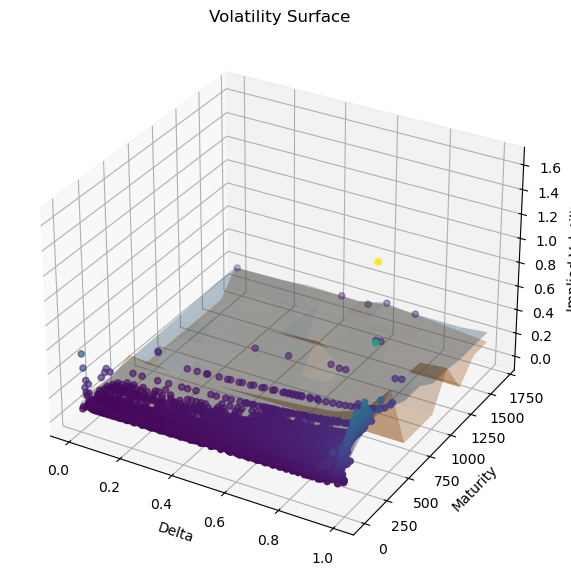

In [6]:
date = '2023-05-10'
delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'delta']
delta = np.where(delta > 0, delta, 1 + delta)
maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'ttm']
vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'impl_volatility']
X = np.column_stack([delta, maturity])
y = vol

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')

ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title('3D Scatter Plot of Delta, Maturity, and Volatility')

interp_model_predictions = GridInterpVolSurface(kx=1, ky=1)
interp_model_predictions.fit(X, y)
interp_y_pred = interp_model_predictions.predict(X)

interp_model_predictions.plot(ax=ax, alpha=0.3)

kernel_model_predictions = KernelVolSurface()
kernel_model_predictions.fit(X, y)
kernel_y_pred = kernel_model_predictions.predict(X)
kernel_model_predictions.plot(ax=ax, alpha=0.3)


plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

# Define maturity thresholds
maturity_thresholds = [750, 1250, 1750, 1e5]

unique_dates = df_active['date'].unique()
results = {}

# Loop through each maturity threshold
for threshold in maturity_thresholds:
    print(f"Processing maturity threshold: {threshold}")
    results[threshold] = {}

    # Loop through each date
    for date in unique_dates:
        # print(f"  Processing date: {date}")

        # Filter data for the current date and maturity threshold
        delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'delta']
        delta = np.where(delta > 0, delta, 1 + delta)  # Adjust delta values
        maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'ttm']
        vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'impl_volatility']

        # Skip if no data is available for the current date and threshold
        if len(delta) == 0 or len(maturity) == 0 or len(vol) == 0:
            print(f"    No data for date {date} and threshold {threshold}")
            continue

        # Prepare input data
        X = np.column_stack([delta, maturity])
        y = vol

        # Kernel Model
        kernel_model = KernelVolSurface()
        kernel_model.fit(X, y)
        kernel_y_pred = kernel_model.predict(X)

        # Calculate Mean Squared Error
        mse_kernel = mean_squared_error(y, kernel_y_pred)

        # Store results
        results[threshold][date] = {
            "mse_kernel": mse_kernel,
            "kernel_model": kernel_model,
            "kernel_y_pred": kernel_y_pred,
            "X": X,
            "y": y
        }



Processing maturity threshold: 750
Processing maturity threshold: 1250
Processing maturity threshold: 1750
Processing maturity threshold: 100000.0


In [16]:
import json

# Define the file path to save the results
output_file = CSV_PATH + "/kernel_volsurface_results.json"

# Prepare the results for saving
# Convert numpy arrays to lists for JSON serialization
serializable_results = {}
for threshold, dates in results.items():
    serializable_results[threshold] = {}
    for date, data in dates.items():
        serializable_results[threshold][str(date)] = {
            "mse_kernel": data["mse_kernel"],
            "kernel_y_pred": data["kernel_y_pred"].tolist(),  # Convert numpy array to list
            "X": data["X"].tolist(),  # Convert numpy array to list
            "y": data["y"].tolist()  # Convert numpy array to list
        }

# Save the results to a JSON file
with open(output_file, "w") as f:
    json.dump(serializable_results, f, indent=4)

print(f"Results saved to {output_file}")

Results saved to /Users/zlx/Library/CloudStorage/GoogleDrive-xiangzhuolin19@gmail.com/.shortcut-targets-by-id/1rlGhvhL5snFV5BcipwCIz6FBIkGrjXAS/OptionMetrics_SPX_options/kernel_volsurface_results.json


## read the generated vol surface json file

/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_87791/3455067547.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_kernel_comparison.values(), labels=mse_kernel_comparison.keys())


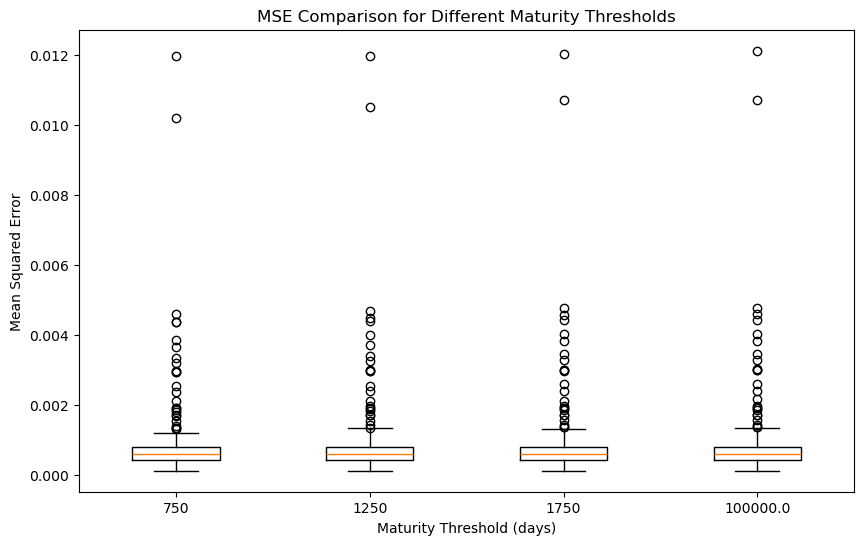

In [21]:
with open(output_file, "r") as f:
    loaded_results = json.load(f)

# Extract mse_kernel for each threshold
mse_kernel_comparison = {}
for threshold in loaded_results:
    mse_kernel_comparison[threshold] = []
    for date in loaded_results[threshold]:
        mse_kernel_comparison[threshold].append(loaded_results[threshold][date]["mse_kernel"])

# draw boxplot
import matplotlib.pyplot as plt

# Create a boxplot for each maturity threshold
plt.figure(figsize=(10, 6))
plt.boxplot(mse_kernel_comparison.values(), labels=mse_kernel_comparison.keys())
plt.xlabel('Maturity Threshold (days)')
plt.ylabel('Mean Squared Error')    
plt.title('MSE Comparison for Different Maturity Thresholds')
plt.show()

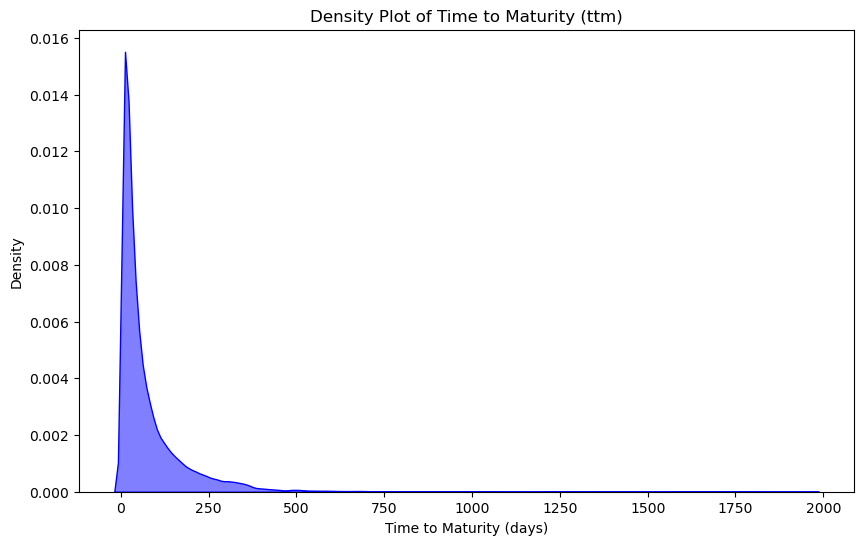

In [24]:
# Create a density plot for all ttm
plt.figure(figsize=(10, 6))
sns.kdeplot(df_active['ttm'], fill=True, color='blue', alpha=0.5)
plt.title('Density Plot of Time to Maturity (ttm)')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Density')
plt.show()

In [ ]:
# let's first fix the maturity grid points to be [1, 7, 30, 60, 90, 180, 360, 720]
# fix the delta grid points to be [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# then we can use the kernel model to predict the volatilities on this grid

All kernel_y_pred have the same shape: False
Shapes found: {(5158,), (4502,), (4740,), (5231,), (4749,), (3974,), (4822,), (5487,), (5005,), (2671,), (4895,), (5615,), (5142,), (5261,), (5926,), (5444,), (5935,), (5453,), (3784,), (5462,), (5645,), (5352,), (5416,), (5053,), (5599,), (4397,), (5190,), (5016,), (5025,), (5382,), (5089,), (5327,), (4433,), (5928,), (5336,), (5281,), (5345,), (5464,), (5528,), (5647,), (5046,), (5592,), (5473,), (5766,), (4936,), (5601,), (5000,), (5793,), (5311,), (5256,), (4600,), (5146,), (5265,), (4490,), (5503,), (5210,), (5994,), (3953,), (5567,), (5631,), (4801,), (5521,), (5103,), (5594,), (4938,), (5658,), (5176,), (4520,), (4291,), (5011,), (5249,), (5075,), (5432,), (5258,), (5203,), (5441,), (4785,), (5569,), (5514,), (5578,), (5404,), (5468,), (5770,), (5169,), (5114,), (5059,), (4458,), (3857,), (5242,), (5068,), (4586,), (5132,), (4705,), (5315,), (5324,), (5617,), (5562,), (5443,), (5333,), (5452,), (5323,), (4796,), (5516,), (4805,), (432

Processing date: 2023-03-23T00:00:00.000000000


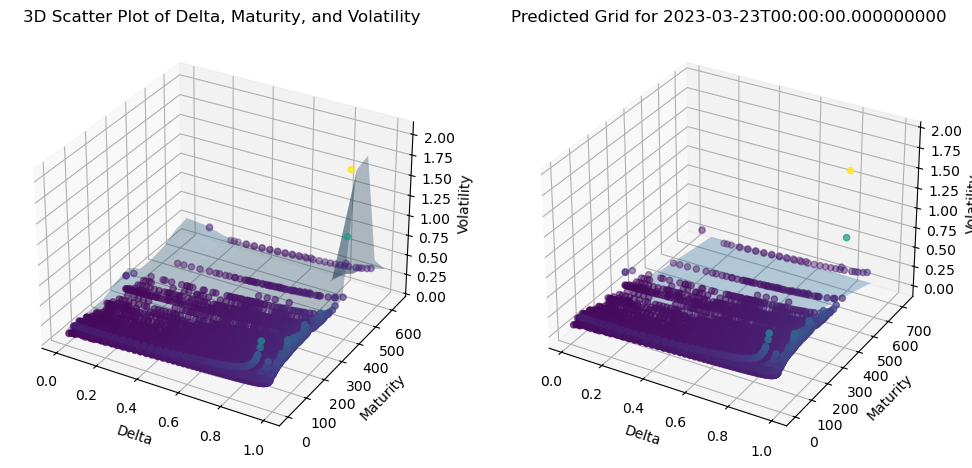

Processing date: 2023-02-09T00:00:00.000000000


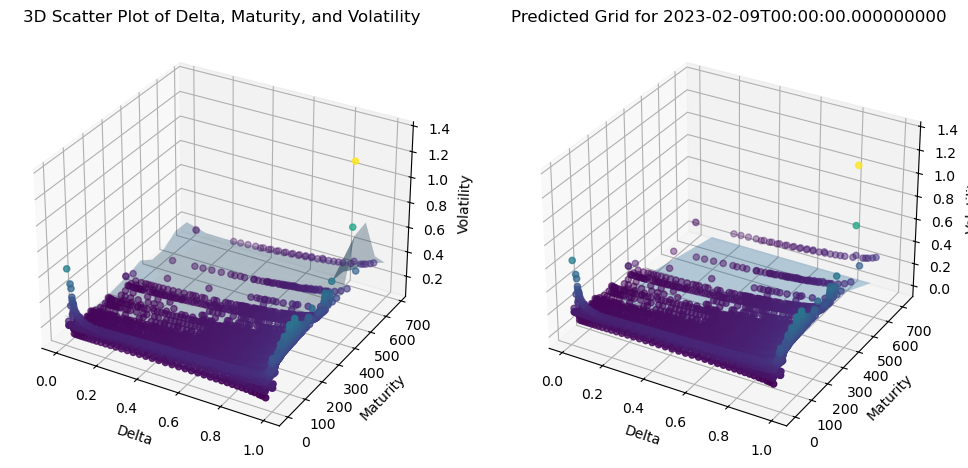

Processing date: 2022-10-03T00:00:00.000000000


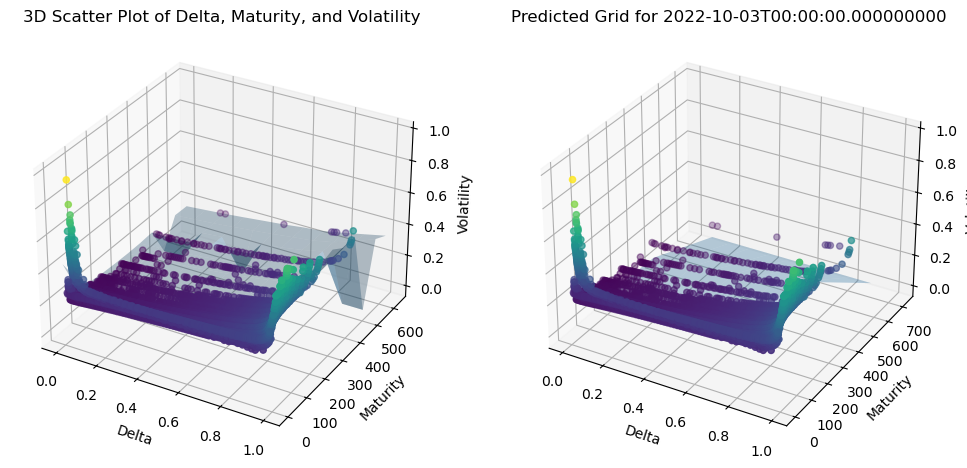

Processing date: 2022-09-21T00:00:00.000000000


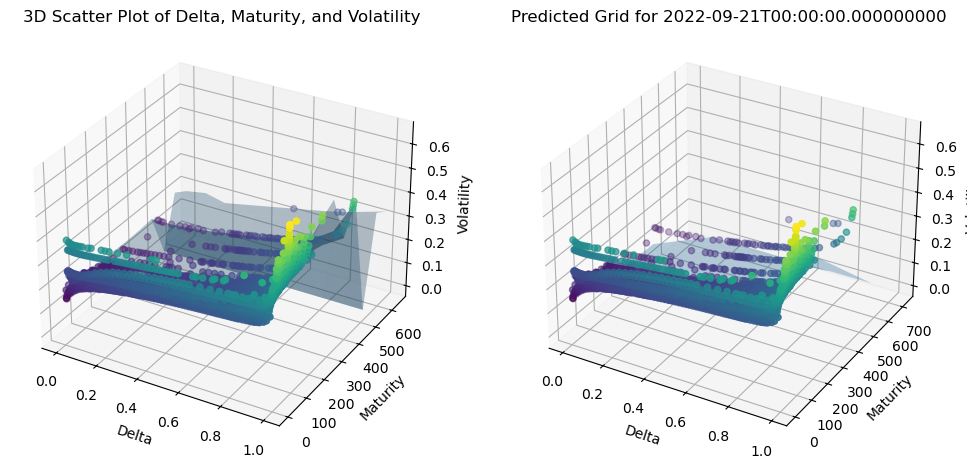

Processing date: 2022-11-14T00:00:00.000000000


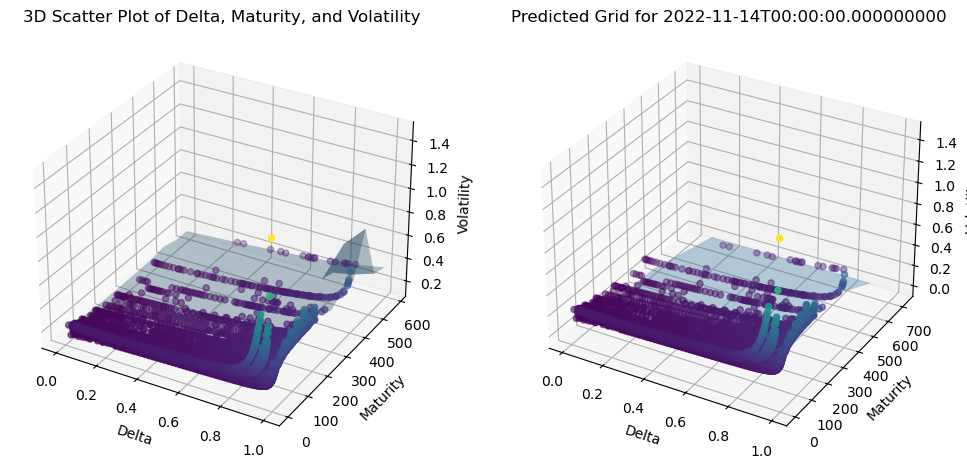

In [36]:
sampled_dates = np.random.choice(unique_dates, size=5, replace=False)

maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Dictionary to store results
grid_results = {}
# grid_results['maturity_grid'] = maturity_grid
# grid_results['delta_grid'] = delta_grid

for date in sampled_dates:
    print(f"Processing date: {date}")

    # Filter data for the current date
    delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'delta']
    delta = np.where(delta > 0, delta, 1 + delta)  # Adjust delta values
    maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'ttm']
    vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'impl_volatility']

    # Skip if no data is available for the current date
    if len(delta) == 0 or len(maturity) == 0 or len(vol) == 0:
        print(f"  No data for date {date}")
        continue

    X = np.column_stack([delta, maturity])
    y = vol
    kernel_model = KernelVolSurface()
    kernel_model.fit(X, y)

    grid_vol = kernel_model.predict_grid(delta_grid, maturity_grid)

    # Store the results
    grid_results[date] = grid_vol

    # plot the original fitted surface and the predicted grid on two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    kernel_model.plot(ax=ax[0], alpha=0.3)
    ax[0].scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')
    ax[0].set_title(f"Original Fitted Surface for {date}")
    ax[0].set_xlabel('Delta')
    ax[0].set_ylabel('Maturity')
    ax[0].set_zlabel('Volatility')
    ax[0].set_title('3D Scatter Plot of Delta, Maturity, and Volatility')
    
    d, m = np.meshgrid(delta_grid, maturity_grid)
    ax[1].plot_surface(d, m, grid_vol.T, alpha=0.3)
    ax[1].scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')
    ax[1].set_title(f"Predicted Grid for {date}")
    ax[1].set_xlabel('Delta')
    ax[1].set_ylabel('Maturity')
    ax[1].set_zlabel('Volatility')
    plt.show()


Processing date: 2023-03-23T00:00:00.000000000


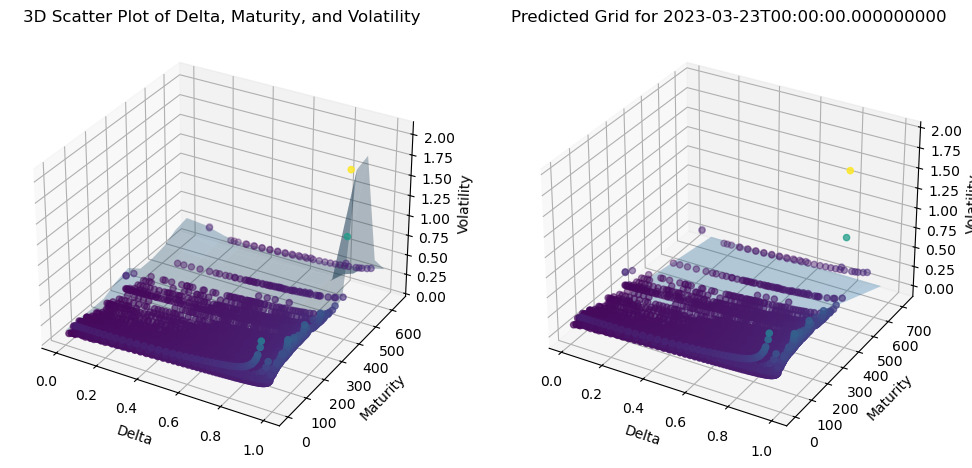

Processing date: 2023-02-09T00:00:00.000000000


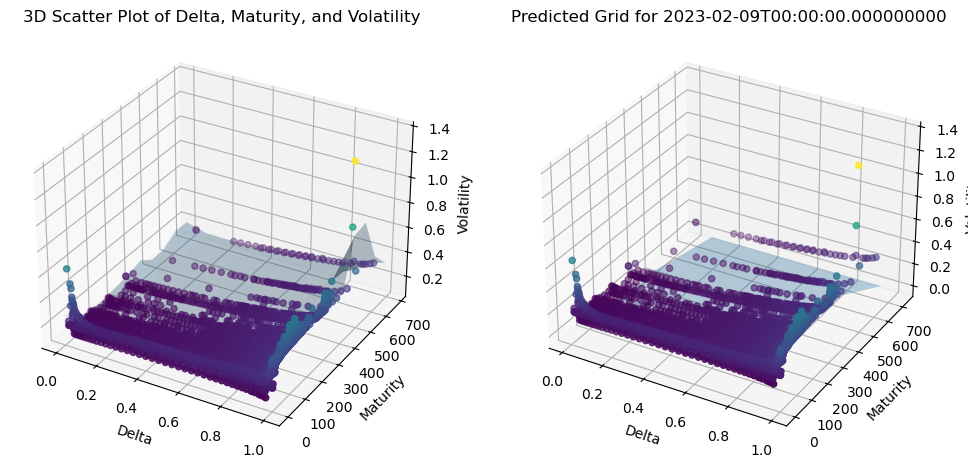

Processing date: 2022-10-03T00:00:00.000000000


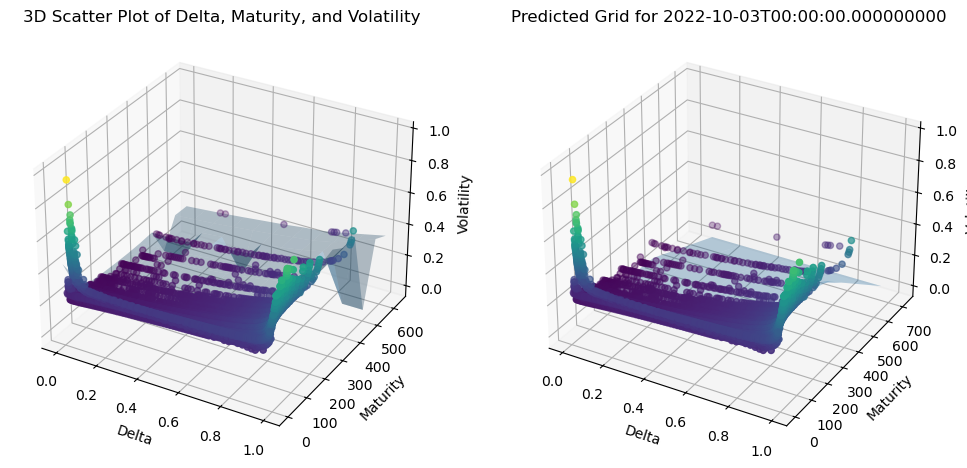

Processing date: 2022-09-21T00:00:00.000000000


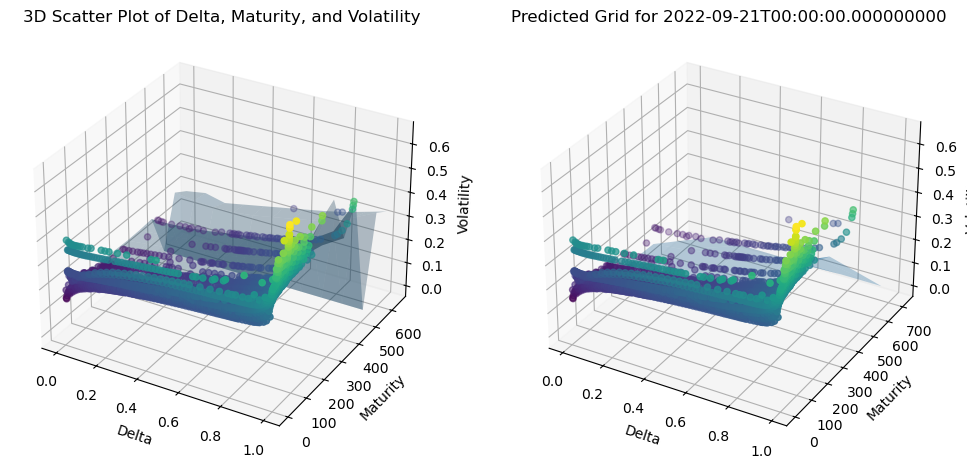

Processing date: 2022-11-14T00:00:00.000000000


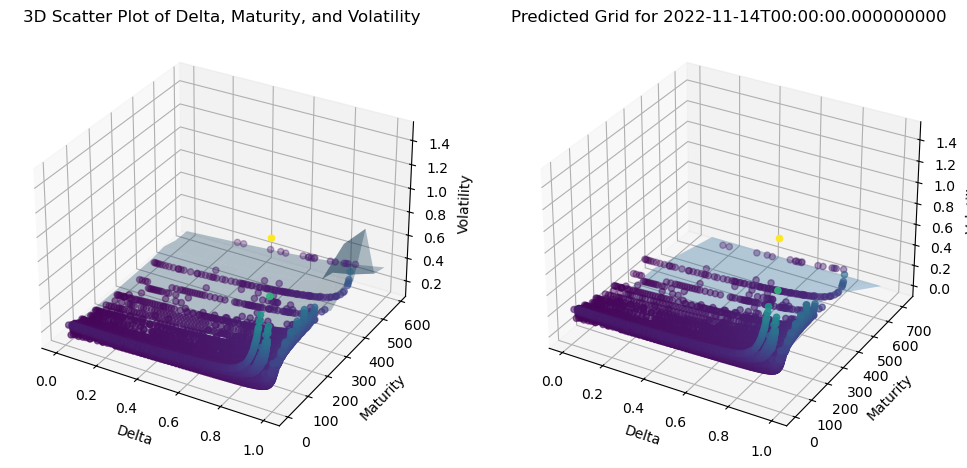

In [38]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

# Dictionary to store results
grid_results = {}
# grid_results['maturity_grid'] = maturity_grid
# grid_results['delta_grid'] = delta_grid

for date in sampled_dates:
    print(f"Processing date: {date}")

    # Filter data for the current date
    delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'delta']
    delta = np.where(delta > 0, delta, 1 + delta)  # Adjust delta values
    maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'ttm']
    vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] <= 750), 'impl_volatility']

    # Skip if no data is available for the current date
    if len(delta) == 0 or len(maturity) == 0 or len(vol) == 0:
        print(f"  No data for date {date}")
        continue

    X = np.column_stack([delta, maturity])
    y = vol
    kernel_model = KernelVolSurface()
    kernel_model.fit(X, y)

    grid_vol = kernel_model.predict_grid(delta_grid, maturity_grid)

    # Store the results
    grid_results[date] = grid_vol

    # plot the original fitted surface and the predicted grid on two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    kernel_model.plot(ax=ax[0], alpha=0.3)
    ax[0].scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')
    ax[0].set_title(f"Original Fitted Surface for {date}")
    ax[0].set_xlabel('Delta')
    ax[0].set_ylabel('Maturity')
    ax[0].set_zlabel('Volatility')
    ax[0].set_title('3D Scatter Plot of Delta, Maturity, and Volatility')
    
    d, m = np.meshgrid(delta_grid, maturity_grid)
    ax[1].plot_surface(d, m, grid_vol.T, alpha=0.3)
    ax[1].scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')
    ax[1].set_title(f"Predicted Grid for {date}")
    ax[1].set_xlabel('Delta')
    ax[1].set_ylabel('Maturity')
    ax[1].set_zlabel('Volatility')
    plt.show()


In [14]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
d, m = np.meshgrid(delta_grid, maturity_grid)

unique_dates = df_active['date'].unique()
predicted_vol_surfaces = {}
predicted_vol_surfaces['delta'] = d.flatten()
predicted_vol_surfaces['maturity'] = m.flatten()

for date in unique_dates:
    print(f"Processing date: {date}")

    # Filter data for the current date
    delta = df_active.loc[(df_active['date'] == date), 'delta']
    delta = np.where(delta > 0, delta, 1 + delta)  # Adjust delta values
    maturity = df_active.loc[(df_active['date'] == date), 'ttm']
    vol = df_active.loc[(df_active['date'] == date), 'impl_volatility']

    if len(delta) == 0 or len(maturity) == 0 or len(vol) == 0:
        print(f"  No data for date {date}")
        continue
    X = np.column_stack([delta, maturity])
    y = vol
    kernel_model = KernelVolSurface()
    kernel_model.fit(X, y)

    grid_vol = kernel_model.predict_grid(delta_grid, maturity_grid)

    predicted_vol_surfaces[str(date)] = grid_vol.flatten()

output_file = CSV_PATH + "/predicted_vol_surfaces_pw.csv"
# Save the predicted vol surfaces to a CSV file
predicted_vol_surfaces_df = pd.DataFrame(predicted_vol_surfaces)
predicted_vol_surfaces_df.to_csv(output_file, index=False)
print(f"Predicted vol surfaces saved to {output_file}")
    
# Define the output file path
# output_file = CSV_PATH + "/predicted_vol_surfaces.json"

# Save the predicted vol surfaces to a JSON file
# with open(output_file, "w") as f:
#     json.dump(predicted_vol_surfaces, f, indent=4)

# print(f"Predicted vol surfaces saved to {output_file}")

Processing date: 2022-08-31 00:00:00
Processing date: 2022-09-01 00:00:00
Processing date: 2022-09-02 00:00:00
Processing date: 2022-09-06 00:00:00
Processing date: 2022-09-07 00:00:00
Processing date: 2022-09-08 00:00:00
Processing date: 2022-09-09 00:00:00
Processing date: 2022-09-12 00:00:00
Processing date: 2022-09-13 00:00:00
Processing date: 2022-09-14 00:00:00
Processing date: 2022-09-15 00:00:00
Processing date: 2022-09-16 00:00:00
Processing date: 2022-09-19 00:00:00
Processing date: 2022-09-20 00:00:00
Processing date: 2022-09-21 00:00:00
Processing date: 2022-09-22 00:00:00
Processing date: 2022-09-23 00:00:00
Processing date: 2022-09-26 00:00:00
Processing date: 2022-09-27 00:00:00
Processing date: 2022-09-28 00:00:00
Processing date: 2022-09-29 00:00:00
Processing date: 2022-09-30 00:00:00
Processing date: 2022-10-03 00:00:00
Processing date: 2022-10-04 00:00:00
Processing date: 2022-10-05 00:00:00
Processing date: 2022-10-06 00:00:00
Processing date: 2022-10-07 00:00:00
P

In [12]:
predicted_vol_surfaces


{'delta': array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]),
 'maturity': array([[  1,   1,   1,   1,   1,   1,   1,   1,   1],
        [  7,   7,   7,   7,   7,   7,   7,   7,   7],
        [ 30,  30,  30,  30,  30,  30,  30,  30,  30],
        [ 60,  60,  60,  60,  60,  60,  60,  60,  60],
        [ 90,  90,  90,  90,  90,  90,  90,  90,  90],
        [180, 180, 180, 180, 180, 180, 180, 180, 180],
        [360, 360, 360, 360, 360, 360, 360, 360, 360],
        [720, 720, 720, 720, 720, 720, 720, 720, 720]]),
 '2022-08-31 00:00:00': array([1.83528856e-01, 1.91889726e-01, 1.92044932e-01, 1.81409232e-01,


In [3]:
import os
os.chdir('/Users/zlx/Desktop/2025Spring/COS513/VAE-VolSurface')


import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

model_name = "vae_v2"
train_model = True
load_model = False
save_model = True
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

# Initialize the trainer
trainer = Trainer(model_name)

if train_model:
    trainer.create_model()

    if load_model:
        trainer.load_model(f"params/{trainer.model_name}.pth")
    else:
        print("Training from scratch")

        # Create dataset
        transform = transforms.Compose([transforms.ToTensor()])
        # Load the JSON file
        with open(data_dir, "r") as f:
            data = json.load(f)

        vol_surfaces = []
        for key in data:
            surface = torch.tensor(data[key], dtype=torch.float32)
            vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

        data_tensor = torch.stack(vol_surfaces)
        dummy_labels = torch.zeros(len(data_tensor))

        dataset = TensorDataset(data_tensor, dummy_labels)
        train_loader = DataLoader(
            dataset, 
            batch_size=trainer.batch_size,
            shuffle=True
        )

        # Train the model
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            trainer.train(train_loader)

        if save_model:
            torch.save(
                trainer.model.state_dict(), f"params/{trainer.model_name}.pth"
            )

        print("Training complete.")

    # Evaluate the model
    trainer.evaluate("output")

[2025-04-13 17:10:28] [INFO] src.train: Using device: mps


Training from scratch
Epoch 1/10


[2025-04-13 17:10:28] [INFO] src.train: Loss: 6.5255
[2025-04-13 17:10:28] [INFO] src.train: Loss: 4.0111
[2025-04-13 17:10:28] [INFO] src.train: Loss: 2.3904
[2025-04-13 17:10:28] [INFO] src.train: Loss: 1.4648
[2025-04-13 17:10:28] [INFO] src.train: Loss: 0.9000


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10


[2025-04-13 17:10:28] [INFO] src.train: Loss: 0.7251
[2025-04-13 17:10:28] [INFO] src.train: Loss: 0.5871
[2025-04-13 17:10:28] [INFO] src.train: Loss: 0.4949
[2025-04-13 17:10:29] [INFO] src.train: Loss: 0.4414
[2025-04-13 17:10:29] [INFO] src.train: Loss: 0.4410


Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Training complete.


In [76]:
for batch_idx, (data, _) in enumerate(train_loader):
    print(data.shape)

torch.Size([128, 72])
torch.Size([124, 72])


In [78]:
28*28

784

In [54]:
from src.utils.yaml_helper import YamlParser
YamlParser('/Users/zlx/Desktop/2025Spring/COS513/VAE-VolSurface/src/models/vae_v2.yaml').load_yaml()

{'model': {'type': 'vae', 'data': 'volsurfaces'},
 'train': {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001},
 'network': {'latent_dim': 20, 'input_dim': 784, 'hidden_dim': 100},
 'hypertune': {'learning_rate': [0.001, 0.0001]}}

In [56]:
trainer = Trainer('vae_v1')

[2025-04-13 15:37:07] [ERROR] src.train: Model configs not found


In [57]:
import os
print(os.getcwd())

/Users/zlx/Desktop/2025Spring/COS513/VAE-VolSurface/examples


In [59]:
import os
print(os.getcwd())

/Users/zlx/Desktop/2025Spring/COS513/VAE-VolSurface


In [ ]:
train_loader